Here is a simpler example of the use of LIME for image classification by using Keras (v2 or greater)

In [1]:
import os
import keras
from keras.applications import vgg16 as inc_net
from keras.preprocessing import image
from keras.applications.imagenet_utils import decode_predictions
from skimage.io import imread
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
print('Notebook run using keras:', keras.__version__)

Using TensorFlow backend.


Notebook run using keras: 2.2.4


# Using VGG16
Here we create a standard VGG16 pretrained model and use it on images by first preprocessing them with the preprocessing tools

In [2]:
inet_model = inc_net.VGG16()

In [3]:
def transform_img_fn(path_list):
    out = []
    for img_path in path_list:
        img = image.load_img(img_path, target_size=(224, 224))
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x = inc_net.preprocess_input(x)
        out.append(x)
    return np.vstack(out)

## Let's see the top 5 prediction for some image

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


('n02877765', 'bottlecap', 0.422296)
('n07873807', 'pizza', 0.2849911)
('n02776631', 'bakery', 0.07872792)
('n07613480', 'trifle', 0.057947345)
('n03201208', 'dining_table', 0.02842388)


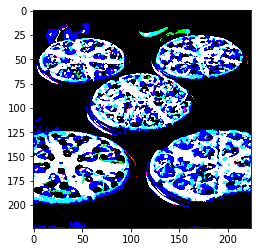

In [4]:
images = transform_img_fn([os.path.join('data','pizza-2.png')])
# I'm dividing by 2 and adding 0.5 because of how this Inception represents images
plt.imshow(images[0])
preds = inet_model.predict(images)
for x in decode_predictions(preds)[0]:
    print(x)

## Explanation
Now let's get an explanation

In [5]:
%load_ext autoreload
%autoreload 2
import os,sys
try:
    import lime
except:
    sys.path.append(os.path.join('..', '..')) # add the current directory
    import lime
from lime import lime_image

In [6]:
explainer = lime_image.LimeImageExplainer()

hide_color is the color for a superpixel turned OFF. Alternatively, if it is NONE, the superpixel will be replaced by the average of its pixels. Here, we set it to 0 (in the representation used by inception model, 0 means gray)

In [7]:
%%time
# Hide color is the color for a superpixel turned OFF. Alternatively, if it is NONE, the superpixel will be replaced by the average of its pixels
explanation = explainer.explain_instance(images[0], inet_model.predict, top_labels=5, hide_color=0, num_samples=1000)

/home/elisa/Desktop/Ebano/venv/lib/python3.5/site-packages/sklearn/linear_model/ridge.py:165: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number4.011915e-19
  overwrite_a=False)
/home/elisa/Desktop/Ebano/venv/lib/python3.5/site-packages/sklearn/linear_model/ridge.py:165: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number4.011915e-19
  overwrite_a=False)
/home/elisa/Desktop/Ebano/venv/lib/python3.5/site-packages/sklearn/linear_model/ridge.py:165: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number4.011915e-19
  overwrite_a=False)
/home/elisa/Desktop/Ebano/venv/lib/python3.5/site-packages/sklearn/linear_model/ridge.py:165: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciproca

CPU times: user 37min 4s, sys: 2min 32s, total: 39min 36s
Wall time: 9min 21s


Image classifiers are a bit slow. Notice that an explanation on my Surface Book dGPU took 1min 29s

### Now let's see the explanation for the top class ( bottlecap)

We can see the top 5 superpixels that are most positive towards the class with the rest of the image hidden

In [8]:
from skimage.segmentation import mark_boundaries

In [9]:
labels = list(explanation.local_exp.keys())

In [10]:
labels

[415, 532, 455, 963, 927]

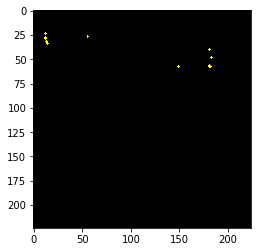

In [11]:
temp, mask = explanation.get_image_and_mask(labels[0], positive_only=True, num_features=5, hide_rest=True)
plt.imshow(mark_boundaries(temp, mask))

Or with the rest of the image present:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


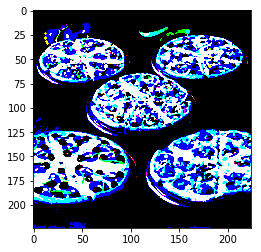

In [12]:
temp, mask = explanation.get_image_and_mask(labels[0], positive_only=True, num_features=5, hide_rest=False)
plt.imshow(mark_boundaries(temp, mask))


We can also see the 'pros and cons' (pros in green, cons in red)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


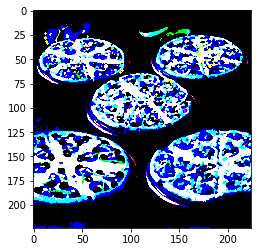

In [13]:
temp, mask = explanation.get_image_and_mask(labels[0], positive_only=False, num_features=10, hide_rest=False)
plt.imshow(mark_boundaries(temp, mask))

Or the pros and cons that have weight at least 0.1

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


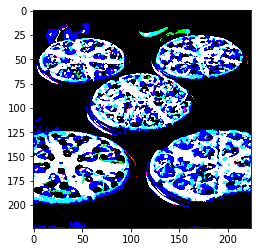

In [14]:
temp, mask = explanation.get_image_and_mask(labels[0], positive_only=False, num_features=1000, hide_rest=False, min_weight=0.1)
plt.imshow(mark_boundaries(temp, mask))

### Let's see the explanation for Pizza

Most positive towards mouse:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


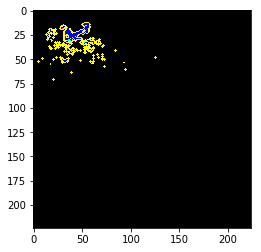

In [15]:
temp, mask = explanation.get_image_and_mask(labels[1], positive_only=True, num_features=5, hide_rest=True)
plt.imshow(mark_boundaries(temp, mask))

Pros and cons:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


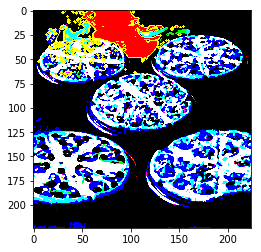

In [16]:
temp, mask = explanation.get_image_and_mask(labels[1], positive_only=False, num_features=10, hide_rest=False)
plt.imshow(mark_boundaries(temp, mask))
